In [42]:
# packages used in this tutorial 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow as tf
from tensorflow import keras

# gradient boosting 
from xgboost import XGBRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# evaluation metrics
from sklearn.metrics import mean_squared_error

#For the decision tree graphic
#Need: pip install pydot and pip install graphviz and sudo pip install pydot and pip install graphviz, update nope need to install homebrew then: brew install graphviz
import pydot
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [43]:
#Dataset 
df = pd.read_csv('v2refined74.csv')
#print(df.head())
print(df.columns)

Index(['Number of Carbons', 'Number of Fluorines', 'Contains N', 'Contains O',
       'Contains S', 'MONOISOTOPIC_MASS', 'AVERAGE_MASS',
       'DENSITY_G/CM^3_TEST_PRED', 'MELTING_POINT_DEGC_TEST_PRED',
       'ATMOSPHERIC_HYDROXYLATION_RATE_(AOH)_CM3/MOLECULE*SEC_OPERA_PRED',
       'BIOCONCENTRATION_FACTOR_OPERA_PRED',
       'BIODEGRADATION_HALF_LIFE_DAYS_DAYS_OPERA_PRED',
       'BOILING_POINT_DEGC_OPERA_PRED', 'HENRYS_LAW_ATM-M3/MOLE_OPERA_PRED',
       'OPERA_KM_DAYS_OPERA_PRED',
       'OCTANOL_AIR_PARTITION_COEFF_LOGKOA_OPERA_PRED',
       'SOIL_ADSORPTION_COEFFICIENT_KOC_L/KG_OPERA_PRED',
       'OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED',
       'MELTING_POINT_DEGC_OPERA_PRED', 'VAPOR_PRESSURE_MMHG_OPERA_PRED',
       'WATER_SOLUBILITY_MOL/L_OPERA_PRED'],
      dtype='object')


In [44]:
#first, separate the full df into 2 by rows assigning some % of the rows to training and some to testing, for example by

train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)

#in this way you slice your data horizontally.

In [45]:
#then, identify which columns should be in your training data (X) and which in your training labels(Y). Then explicitly select them:

train_X = train[['Number of Carbons','Number of Fluorines','Contains N','Contains O','Contains S','MONOISOTOPIC_MASS']].values.astype(float)
train_Y = train['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_OPERA_PRED'].values.astype(float) 

#Note that columns should be the same for training and testing, including the order:

test_X = test[['Number of Carbons','Number of Fluorines','Contains N','Contains O','Contains S','MONOISOTOPIC_MASS']].values.astype(float)
test_Y = test['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_OPERA_PRED'].values.astype(float) 



In [46]:
print("Training set: {}".format(train_X.shape))  # 59 examples, 6 features
print("Testing set:  {}".format(test_X.shape))   # 15 examples, 6 features

Training set: (52, 6)
Testing set:  (13, 6)


In [47]:
column_names = ['Number of Carbons','Number of Fluorines','Contains N','Contains O','Contains S','MONOISOTOPIC_MASS']

dfTrain = pd.DataFrame(train_X, columns=column_names)
dfTrain.head()

,Number of Carbons,Number of Fluorines,Contains N,Contains O,Contains S,MONOISOTOPIC_MASS
0,6.0,11.0,0.0,0.0,0.0,281.990260
1,5.0,9.0,0.0,1.0,0.0,247.988368
2,3.0,6.0,1.0,0.0,0.0,167.016968
3,8.0,15.0,0.0,1.0,0.0,413.973702
4,9.0,17.0,0.0,1.0,0.0,463.970508


In [48]:
print(train_Y[0:10])  # Display first 10 entries

[4.46752 4.45077 7.5656  4.94317 4.9418  3.67833 3.6757  6.58506 3.67813
 6.75326]


In [49]:
#Sherpa parameter optimization
import time
import sherpa
import sherpa.algorithms.bayesian_optimization as bayesian_optimization

In [26]:
#SHERPA Parameter Optimization
from sklearn.model_selection import cross_val_score
parameters = [sherpa.Discrete('n_estimators', [2, 100]),
              #sherpa.Choice('criterion', ['mse', 'rmse']),
              sherpa.Continuous('max_features', [0.1, 0.9])]

algorithm = bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP_MCMC',
                                         acquisition_type='EI_MCMC',
                                         max_num_trials=10)

study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    regressor = RandomForestRegressor(max_features=trial.parameters['max_features'],
                                 n_estimators=trial.parameters['n_estimators'],
                                 random_state=0)
    scores = cross_val_score(regressor, train_X, train_Y, cv=5)
    print("Score: ", scores.mean())
    study.add_observation(trial, iteration=1, objective=scores.mean())
    study.finalize(trial)
print(study.get_best_result())

KeyboardInterrupt: 

In [50]:
#======================================================
# setup model parameters, choose RFR or XGB
# if you comment out a parameter it will use default value
#======================================================
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':1000,
              'criterion':'mse', 
              #'ccp_alpha':0.001,
              'max_depth': 10,
              #'min_samples_leaf':1,
              #'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}


# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              #'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 2000,  # number of trees to use
              #'learning_rate': 0.01, 
              'max_depth': 20,       # how many levels are in each tree
              #'subsample': 1,
              #'colsample_bytree': 0.8,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 0,
              'reg_lambda': 1,}

In [51]:
#======================================================
# define the model, uncomment the one you want to use
#======================================================
model = RandomForestRegressor(**params_rfr)
#model = XGBRegressor(**params_xgb)

In [52]:
%%time
model.fit(train_X, train_Y)

CPU times: user 1.66 s, sys: 56.8 ms, total: 1.72 s
Wall time: 1.81 s


RandomForestRegressor(max_depth=10, max_features=None, n_estimators=1000)

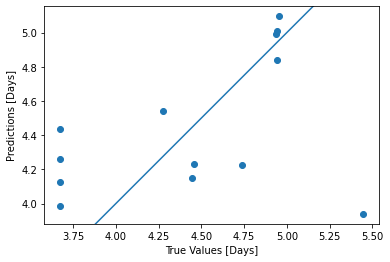

In [53]:
test_predictions = model.predict(test_X)

plt.scatter(test_Y, test_predictions)
plt.xlabel('True Values [Days]')
plt.ylabel('Predictions [Days]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

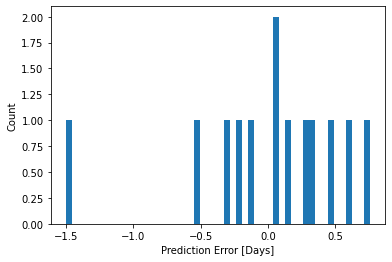

In [54]:
# histogram
error = test_predictions - test_Y
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [Days]")
_ = plt.ylabel("Count")

In [55]:
mse = mean_squared_error(test_Y, test_predictions)
print(f'the mse is {mse}')

the mse is 0.3072011398967607


In [33]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

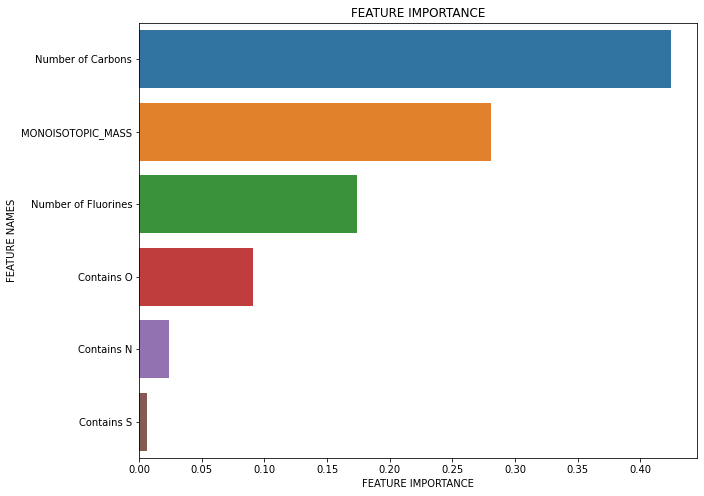

In [34]:
plot_feature_importance(model.feature_importances_, dfTrain.columns)

In [35]:
#Extract List of features from data frame.
feature_list = list(dfTrain.columns)
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Number of Carbons    Importance: 0.42
Variable: MONOISOTOPIC_MASS    Importance: 0.28
Variable: Number of Fluorines  Importance: 0.17
Variable: Contains O           Importance: 0.09
Variable: Contains N           Importance: 0.02
Variable: Contains S           Importance: 0.01


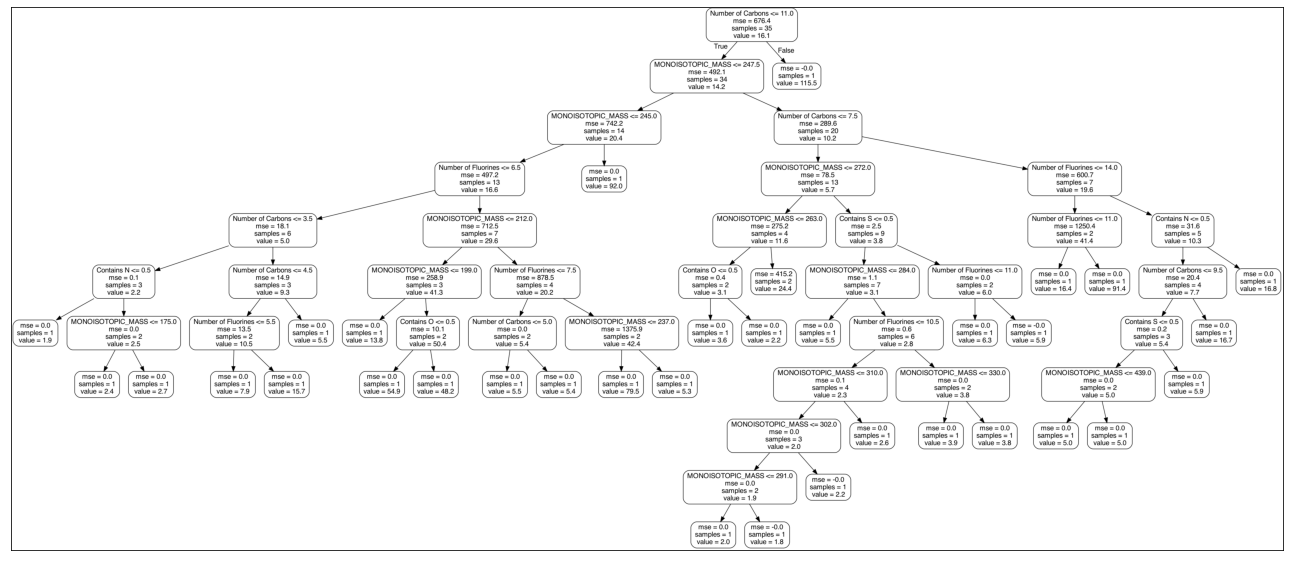

In [36]:
def plot_decisiontree(img_name):
    tree_image = plt.imread(img_name)
    plt.figure(figsize=(100,10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(tree_image)
    plt.show()
rf_tree = model.estimators_[5]
export_graphviz(rf_tree, out_file = 'rf.dot', feature_names = feature_list, rounded = True, precision = 1)
# Write graph to a png file
(graph_rf, ) = pydot.graph_from_dot_file('rf.dot')
graph_rf.write_png('rf.png')
plot_decisiontree('rf.png')